#### Machine Learning Ass. 1
##### BE_34_Samruddhi Khairnar

##### Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
##### Dataset link:https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [408]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [409]:
%cd /content/drive/MyDrive/BE_Datasets/

/content/drive/MyDrive/BE_Datasets


In [410]:
%ls

6_dataset.csv  emails.csv   locations.txt          uber.csv
diabetes.csv   lat_lon.txt  sales_data_sample.csv


# 1. Pre-process the dataset.


In [411]:
import pandas as pd
df = pd.read_csv('uber.csv')

In [412]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0


In [413]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [414]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64

In [415]:
df.dropna(inplace=True)

In [416]:
df.drop('Unnamed: 0', inplace=True, axis='columns')

In [417]:
df.isnull().sum().sum()

0

In [418]:
df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

# 2. Identify outliers.


In [419]:
import seaborn as sns
import matplotlib.pyplot as plt

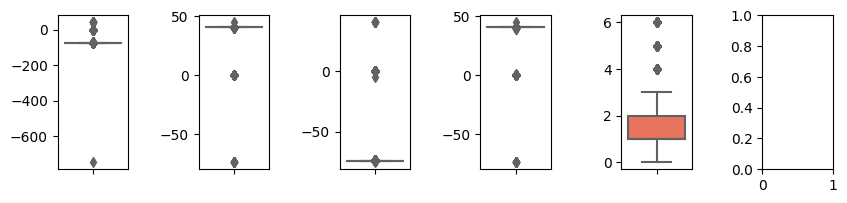

In [420]:
fig, ax = plt.subplots(1,6, figsize=(10,2))
plt.subplots_adjust(wspace=1)
for i,j in enumerate(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']):
  sns.boxplot(ax=ax[i], y=df[j].values, color='tomato')
plt.show();

In [421]:
df2 = df.drop(['key','pickup_datetime'], axis='columns')
q1,q3 = df2.quantile(0.25), df2.quantile(0.75)
iqr = q3 - q1
outliers = ((df2 < q1-1.5*iqr) | (df2 > q3+1.5*iqr))
outliers.sum()

fare_amount          2166
pickup_longitude     1834
pickup_latitude      1234
dropoff_longitude    1893
dropoff_latitude     1615
passenger_count      2941
dtype: int64

In [422]:
import numpy as np
df2.where(outliers, df2.mean(), inplace=True, axis=1)

In [423]:
df2['key'] = df.key
df2['pickup_datetime'] = df.pickup_datetime
df = df2

# 3. Check the correlation.


<ipython-input-424-ed4eb9922c2f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True);


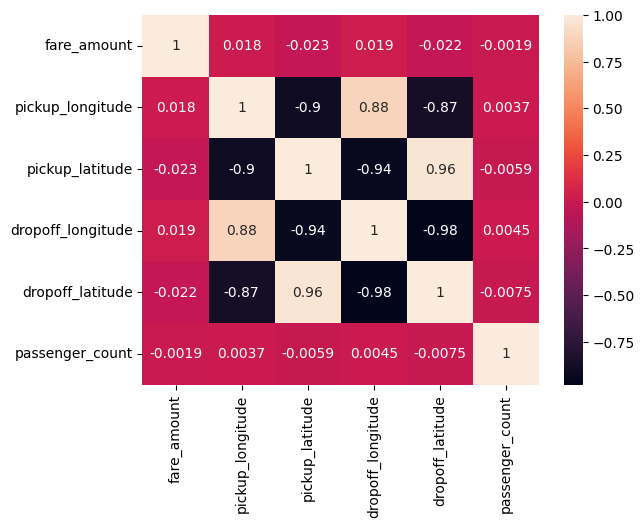

In [424]:
sns.heatmap(df.corr(), annot = True);

In [425]:
# Calculate distances - do not use the normal formula, use Haversine instead
# df['Distance'] = ( (df['pickup_latitude']-df['dropoff_latitude'])**2 + (df['pickup_longitude']-df['dropoff_longitude'])**2 ) ** (1/2)

<h2>Haversine Formula</h2>
<img src="https://community.fabric.microsoft.com/t5/image/serverpage/image-id/965529i9AFD7107A0AABD7E/image-size/large?v=v2&px=999" width="400">

In [426]:
import numpy as mp
R = 6371
df['Distance'] = 2 * R * np.arcsin( ( ( np.sin( (df['pickup_latitude']-df['dropoff_latitude'])/2 ) ** 2 ) + ( np.cos(df['dropoff_latitude']) * np.cos(df['pickup_latitude']) * ( np.sin( (df['pickup_longitude']-df['dropoff_longitude'])/2 ) ** 2 ) ) ) ** (1/2) )

<ipython-input-427-4bf01160af64>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True);


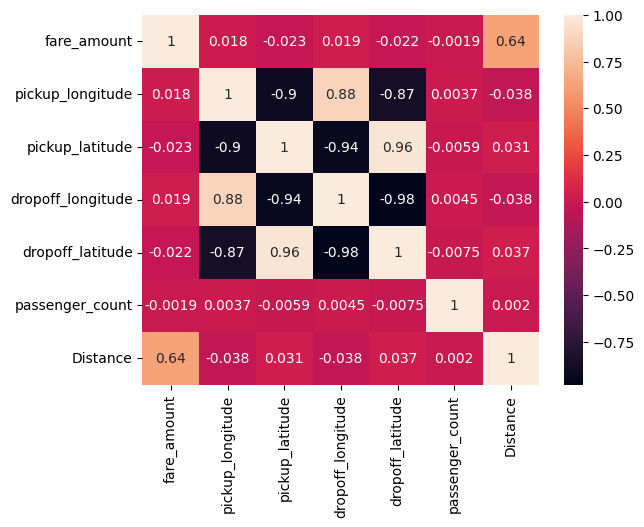

In [427]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr(), annot=True);

# 4. Implement linear regression and random forest regression models.


In [428]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [1473]:
train, test = train_test_split(df, test_size = 0.3, shuffle = True)
X_train, y_train = train.drop(['fare_amount','key','pickup_datetime','pickup_latitude','dropoff_longitude'], axis='columns').values, train['fare_amount'].values
X_test, y_test = test.drop(['fare_amount','key','pickup_datetime','pickup_latitude','dropoff_longitude'], axis='columns').values, test['fare_amount'].values

In [1474]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1475]:
lr = LinearRegression()

In [1476]:
lr.fit(X_train, y_train)

LinearRegression()

In [1477]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

In [1478]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.


In [1479]:
from sklearn.metrics import r2_score, mean_squared_error

In [1480]:
from sklearn.metrics import accuracy_score

In [1481]:
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.45989286105013816

In [1482]:
mean_squared_error(y_test, y_pred) ** (1/2)

5.9432390670262745

In [1483]:
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred)

0.6917055451359275

In [1484]:
mean_squared_error(y_test, y_pred) ** (1/2)

4.4902042641254125